# Python для сбора и анализа данных
## Сравнение matplotlib и seaborn
Есть таблица (`P_Popular Indicators.xlsx`), в которой находятся базовые индикаторы для некоторых стран. Нас интересуют три:

- Population, total - численность населения;
- GDP per capita (current US$) - ВВП на душу населения;
- Life expectancy at birth, total (years) - средняя ожидаемая продолжительность жизни.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

indicators = ['Population, total', 'GDP per capita (current US$)', 'Life expectancy at birth, total (years)']

indicators_df = pd.read_excel('../data/P_Popular Indicators.xlsx').drop(columns=['Series Code'])

indicators_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11072 entries, 0 to 11071
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Series Name    11069 non-null  object
 1   Country Name   11067 non-null  object
 2   Country Code   11067 non-null  object
 3   2019 [YR2019]  11067 non-null  object
 4   2020 [YR2020]  11067 non-null  object
 5   2021 [YR2021]  11067 non-null  object
dtypes: object(6)
memory usage: 519.1+ KB


In [2]:
def extract_index(index_tuple: tuple) -> str:
    first, second = index_tuple

    if not second:
        return first
    
    return second

In [3]:
indicators_data = indicators_df[indicators_df['Series Name'].isin(indicators)].reset_index(drop=True)

# melt year columns (WIDE[years] -> LONG[year])
indicators_data_melt = indicators_data.melt(
    id_vars=['Series Name', 'Country Name'],
    value_vars=['2019 [YR2019]', '2020 [YR2020]', '2021 [YR2021]'],
    var_name='year', value_name='value'
)

# pivot Series Name column (LONG[Series Name] -> WIDE[Series Name])
indicators_data_pivot = indicators_data_melt.pivot(
    columns=['Series Name'], index=['Country Name', 'year'], values=['value']
).reset_index()

# drop multiindex
indicators_data_pivot.columns = indicators_data_pivot.columns.map(extract_index)

# rename_columns
renamer = {
    'Country Name': 'country_name',
    'GDP per capita (current US$)': 'grp_percap',
    'Life expectancy at birth, total (years)': 'life_exp',
    'Population, total': 'population',
}

indicators_data_pivot.rename(columns=renamer, inplace=True)

# transform variables
indicators_data_pivot['year'] = indicators_data_pivot['year'].str[:4].astype(int)

indicators_data_pivot['grp_percap'] = [value if isinstance(value, float) else np.nan for value in indicators_data_pivot['grp_percap']]
indicators_data_pivot['life_exp'] = [value if isinstance(value, float) else np.nan for value in indicators_data_pivot['life_exp']]
indicators_data_pivot['population'] = [value if isinstance(value, int) else np.nan for value in indicators_data_pivot['population']]

indicators_data_pivot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651 entries, 0 to 650
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country_name  651 non-null    object 
 1   year          651 non-null    int64  
 2   grp_percap    608 non-null    float64
 3   life_exp      408 non-null    float64
 4   population    651 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 25.6+ KB


### Визуализация
#### `matplotlib`

Изобразите распределение переменных `indicators_data_pivot.grp_percap`, `indicators_data_pivot.life_exp` и `indicators_data_pivot.population` с помощью:

1. Гистограммы;
2. Ящика с усами (boxplot).

На одном графике. Используйте данные на 2019 год.

In [4]:
indicators_data_pivot.head()

,country_name,year,grp_percap,life_exp,population
0,Afghanistan,2019,500.522664,63.565,37769499
1,Afghanistan,2020,516.866552,62.575,38972230
2,Afghanistan,2021,368.754614,NaN,40099462
3,Albania,2019,5396.215864,79.282,2854191
4,Albania,2020,5332.160475,76.989,2837849


In [31]:
indicators_data_pivot2019 = indicators_data_pivot[indicators_data_pivot['year'] == 2019].reset_index(drop=True)
indicators_data_pivot2019.head()

,country_name,year,grp_percap,life_exp,population
0,Afghanistan,2019,500.522664,63.565,37769499
1,Albania,2019,5396.215864,79.282,2854191
2,Algeria,2019,4022.150184,76.474,42705368
3,American Samoa,2019,13672.576657,NaN,47321
4,Andorra,2019,41327.502031,NaN,76343


Как строить гистограмму:

In [8]:
sample = [5, -2, 6, 3, 0, 4, 8, 7, 2]
sample_sorted = np.sort(sample)
sample_sorted

array([-2,  0,  2,  3,  4,  5,  6,  7,  8])

In [ ]:
# самое главное в гистограмме - количество bin'ов (столбиков)
# bin = 2  =>

# делим область значений sample_sorted на 2 равные части: [-2, 3), [3, 8]

# далее считаем сколько значений входит в каждый промежуток:

# [-2, 3): 3
# [3, 8]:  6

# схематичное изображение гистограммы:
#   2
#   2
#   2
# 1 2
# 1 2
# 1 2

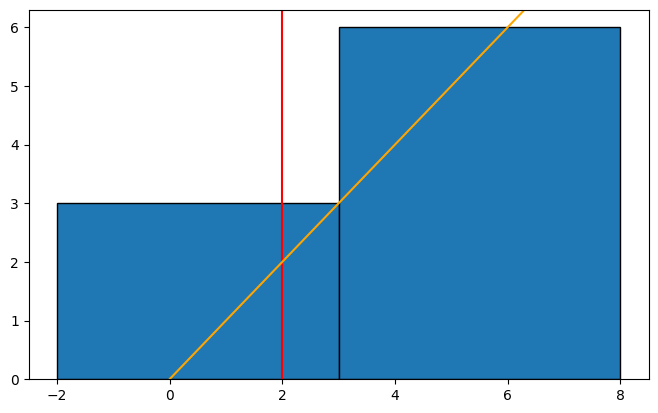

In [27]:
fig, ax = plt.subplots()

fig.set_figwidth(8)

counts, limits, bars = ax.hist(sample_sorted, bins=2, edgecolor='black')

ax.axvline(2, color='red');
ax.axline((0, 0), (5, 5), color='orange');

Полный код построения графика:

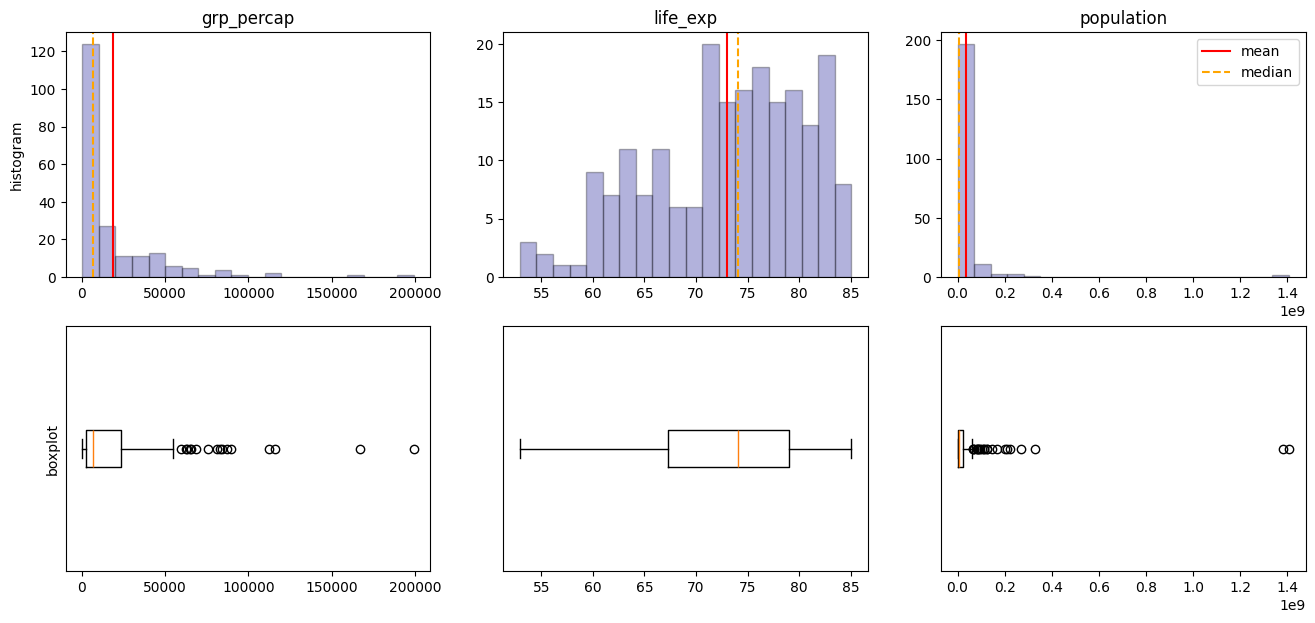

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(16, 7))

columns = ['grp_percap', 'life_exp', 'population']

for index, variable in enumerate(columns):
    data_variable = indicators_data_pivot2019[variable].dropna(ignore_index=True)
    
    variable_mean = data_variable.mean()
    variable_median = data_variable.median()
    
    ## histogram
    axes[0, index].hist(data_variable, edgecolor='black', bins=20, color='darkblue', alpha=.3)
    axes[0, index].set_title(variable)

    # add vertical lines for mean and median
    axes[0, index].axvline(variable_mean, color='red', label='mean')  # default linestyle is 'solid'
    axes[0, index].axvline(variable_median, color='orange', linestyle='dashed', label='median')  # for horizontal line use axhline
        # (coordinate Y)

    if index == 0:
        axes[0, index].set_ylabel('histogram')

    # add legend
    if index == 2:
        axes[0, index].legend()

    ## boxplot
    axes[1, index].boxplot(data_variable, vert=False)
    axes[1, index].set_yticks([])

    if index == 0:
        axes[1, index].set_ylabel('boxplot')

#### `seaborn`

Сделайте то же самое, но используя `seaborn`:

In [37]:
indicators_data_pivot2019.shape

(217, 5)

In [34]:
indicators_data_pivot2019_melt = indicators_data_pivot2019.melt(id_vars=['country_name'], value_vars=columns)
indicators_data_pivot2019_melt.head()

,country_name,variable,value
0,Afghanistan,grp_percap,500.522664
1,Albania,grp_percap,5396.215864
2,Algeria,grp_percap,4022.150184
3,American Samoa,grp_percap,13672.576657
4,Andorra,grp_percap,41327.502031


In [38]:
indicators_data_pivot2019[indicators_data_pivot2019['country_name'] == 'Afghanistan']

,country_name,year,grp_percap,life_exp,population
0,Afghanistan,2019,500.522664,63.565,37769499


In [39]:
indicators_data_pivot2019_melt[indicators_data_pivot2019_melt['country_name'] == 'Afghanistan']

,country_name,variable,value
0,Afghanistan,grp_percap,5.005227e+02
217,Afghanistan,life_exp,6.356500e+01
434,Afghanistan,population,3.776950e+07


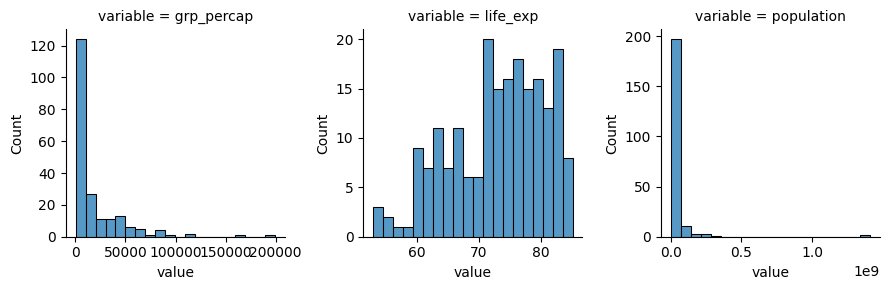

In [35]:
grid = sns.FacetGrid(
    data=indicators_data_pivot2019_melt,
    col='variable',
    col_wrap=3,
    sharex=False,
    sharey=False,
)

grid.map(sns.histplot, 'value', bins=20);

/Users/iadovgopolyi/teaching/lib/python3.11/site-packages/seaborn/axisgrid.py:718: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


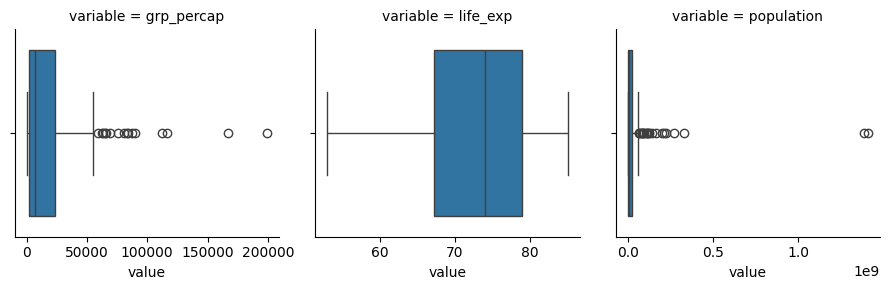

In [20]:
grid = sns.FacetGrid(
    data=indicators_data_pivot2019_melt,
    col='variable',
    col_wrap=3,
    sharex=False,
    sharey=False,
)

grid.map(sns.boxplot, 'value');

Концепция `matplotlib` - много свободы, все рисуем сами из отдельных элементов. Концепция `seaborn` - есть некоторые правила, по которым рисуются графики.